# Setup

In [3]:
import pandas as pd  # Data handling
from scipy.integrate import odeint # numerical integration
import numpy as np
from pyvbmc import VBMC # VMBC object
from pyvbmc import VariationalPosterior
from pyvbmc.priors import SplineTrapezoidal
from scipy.optimize import minimize
import scipy.stats as scs
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from pyvbmc import VariationalPosterior
# import sys
# min = -sys.float_info.max


def derivs(t,curr_vals,a,b):
    x,xd = curr_vals
    xdd = -x - np.sign(x) * a * np.abs(x)**b
    return  xd,xdd

# time array for solution
tmax = 10
dt = 0.05
t = np.arange(0,tmax,dt)

# Range of values that parameters can take on
a_min = 0.0
a_max = 0.5
b_min = 1.0
b_max = 5.0

# Number of parameters (dimension)
D = 2

# Bounds for VBMC object (LB and UB expanded a bit beyond what the actual true values could be)
LB = np.full((1, D), a_min)
LB[0][0] = a_min
LB[0][1] = b_min - 1
UB = np.full((1, D), a_max)
UB[0][0] = a_max + 0.1
UB[0][1] = b_max + 1
PLB = np.copy(LB)
PLB[0][0] = a_min + 0.01
PLB[0][1] = b_min
PUB = np.copy(UB)
PUB[0][0] = a_max 
PUB[0][1] = b_max

# pick a random starting point and do initial minimizatio on it
np.random.seed(4) # leave this
x0_rand = np.random.uniform(PLB, PUB)

#set up prior
prior = SplineTrapezoidal(LB, PLB, PUB, UB)
options = {
    "display": "off"
}

vbmc_count = 0 

print("LB:",LB,"PLB:",PLB,"PUB:",PUB,"UB:",UB,'x0_rand:',x0_rand)

def log_likelihood(theta):
    a,b = theta
    #a = np.exp(a)
    sols = []
    for initial_condition in initial_conditions:
        sol = solve_ivp(derivs,(0,tmax),initial_condition,t_eval = t, args = (a,b), method = "LSODA").y
        sols.append(sol[0])
    big_sol = np.concatenate(sols)
    sliced_sol = big_sol[0::4]
    LL =  np.sum(-(0.5/sigma**2) * (y_true - sliced_sol)**2) #+ np.log(1/(sigma* (2*np.pi)**0.5))
    return LL
    

# pick some nice parameter values to investigate (nonlinear corners and a point in the middle)
a_vals = [0.06,0.06,0.5,0.5,0.28]
b_vals = [1.44,5.0,1.44,5.0,3.22]

initial_conditions = [[0.0, 3.5],[2.0, 0.0],[-0.5, -0.5],[3.14, -0.3]]

sigma = 0.1
noise_sigma = 0.05


LB: [[0. 0.]] PLB: [[0.01 1.  ]] PUB: [[0.5 5. ]] UB: [[0.6 6. ]] x0_rand: [[0.48384462 3.188929  ]]


-22.75915674497154


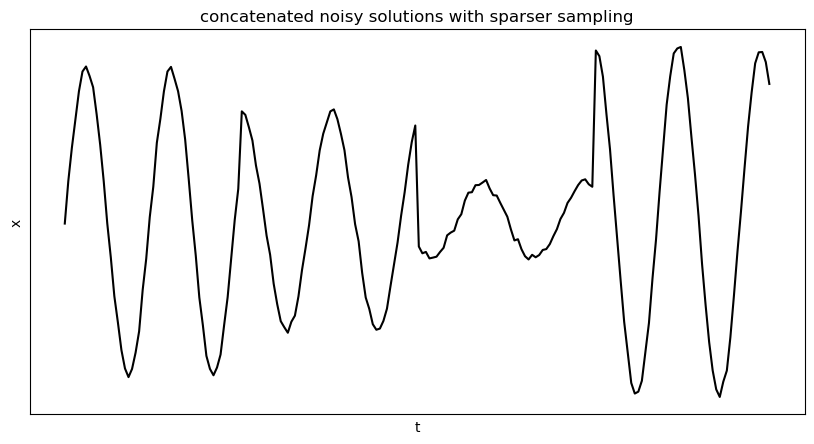

In [4]:
a = 0.3
b = 2.0
sols = []

for initial_condition in initial_conditions:
    sol = solve_ivp(derivs,(0,tmax),initial_condition,t_eval = t, args = (a,b),method = "LSODA").y
    sols.append(sol[0])
big_sol = np.concatenate(sols)
big_t = np.arange(0,4*tmax,dt ) #np.concatenate([t for i in range(4)])
sliced = big_sol[0::4]
noisy_sliced_sol = sliced + noise_sigma * np.random.randn(len(sliced))
y_true = noisy_sliced_sol
print(log_likelihood((a,b)))

plt.figure(figsize=(10,5))
plt.plot(noisy_sliced_sol, color = "black")
plt.title("concatenated noisy solutions with sparser sampling")
plt.xticks([])
plt.yticks([])
plt.grid()
plt.ylabel('x')
plt.xlabel('t')
plt.show()

In [5]:
# options2 = {
#     "display": "iter"
# }

# x0 = np.array([0.301,2.01])
# vbmc = VBMC(log_likelihood, x0, LB, UB, PLB, PUB, prior = prior, options = options2)
# vp, results = vbmc.optimize()

In [6]:
log_likelihood((0.3,2.))

-22.75915674497154

In [28]:
N = 4
a_vals = np.linspace(0.1,0.5,N)
b_vals = np.linspace(1.1,1.5,N)
print(a_vals)
print(b_vals)

[0.1        0.23333333 0.36666667 0.5       ]
[1.1        1.23333333 1.36666667 1.5       ]


# Running and saving

In [14]:
seeds = np.arange(4)
count = 0
for seed in seeds:
    
    for i,a in enumerate(a_vals):

        for j,b in enumerate(b_vals):
            sols = []
            for initial_condition in initial_conditions:
                sol = solve_ivp(derivs,(0,tmax),initial_condition,t_eval = t, args = (a,b),method = "LSODA").y
                sols.append(sol[0])
            big_sol = np.concatenate(sols)
            sliced = big_sol[0::4]
            np.random.seed(seed)
            noisy_sliced_sol = sliced + noise_sigma * np.random.randn(len(sliced))
            y_true = noisy_sliced_sol
            np.random.seed(seed)
            count += 1
            np.random.seed(seed)
            x0 = np.random.uniform(PLB, PUB)
            np.random.seed(seed)
            vbmc = VBMC(log_likelihood, x0, LB, UB, PLB, PUB, prior = prior, options = options)
            np.random.seed(seed)
            vp, results = vbmc.optimize()
            vp.save("vp" + str(i) + "_" +  str(j) + "_" + str(seed) + ".hdf5", overwrite=True)
print(count)

Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -34.086 +/-0.110.
Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -34.164 +/-0.023.
Inference terminated: reached maximum number of function evaluations options.max_fun_evals.
Estimated ELBO: -34.855 +/-0.047.
Caution: Returned variational solution may have not converged.
Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -34.670 +/-0.013.
Inference terminated: reached maximum number of function evaluations options.max_fun_evals.
Estimated ELBO: -632.305 +/-0.716.
Caution: Returned variational solution may have not converged.
Inference terminated: reached maximum number of function evaluations options.max_fun_evals.
Estimated ELBO: -35.363 +/-0.033.
Caution: Returned variational solution may have not converged.
Inference terminated: reached maximum numb

c:\Users\walki\.conda\envs\bpe\Lib\site-packages\cma\evolution_strategy.py:3829: RuntimeWarning: invalid value encountered in scalar subtract
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
c:\Users\walki\.conda\envs\bpe\Lib\site-packages\cma\evolution_strategy.py:3829: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),


Inference terminated: reached maximum number of function evaluations options.max_fun_evals.
Estimated ELBO: -3363.475 +/-0.986.
Caution: Returned variational solution may have not converged.
Inference terminated: reached maximum number of function evaluations options.max_fun_evals.
Estimated ELBO: -7096.766 +/-8.545.
Caution: Returned variational solution may have not converged.
Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -29.569 +/-0.014.
Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -29.687 +/-0.021.
Inference terminated: reached maximum number of function evaluations options.max_fun_evals.
Estimated ELBO: -29.890 +/-0.017.
Caution: Returned variational solution may have not converged.
Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -30.219 +/-0.015.
Inference terminated: variational solut

c:\Users\walki\.conda\envs\bpe\Lib\site-packages\cma\evolution_strategy.py:3823: RuntimeWarning: invalid value encountered in scalar subtract
  current_fitness_range = max(es.fit.fit) - min(es.fit.fit)
c:\Users\walki\.conda\envs\bpe\Lib\site-packages\cma\evolution_strategy.py:3824: RuntimeWarning: invalid value encountered in scalar subtract
  historic_fitness_range = max(es.fit.hist) - min(es.fit.hist)


Inference terminated: reached maximum number of function evaluations options.max_fun_evals.
Estimated ELBO: -1029.379 +/-0.678.
Caution: Returned variational solution may have not converged.
Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -38.720 +/-0.007.
Inference terminated: reached maximum number of function evaluations options.max_fun_evals.
Estimated ELBO: -39.516 +/-1.014.
Caution: Returned variational solution may have not converged.
Inference terminated: reached maximum number of function evaluations options.max_fun_evals.
Estimated ELBO: -6587.565 +/-56.371.
Caution: Returned variational solution may have not converged.
Inference terminated: reached maximum number of function evaluations options.max_fun_evals.
Estimated ELBO: -3391.810 +/-3.337.
Caution: Returned variational solution may have not converged.
Inference terminated: reached maximum number of function evaluations options.max_fun_evals.
Estimated ELBO:

: 

In [88]:
count = 0
seed = 1
vps = np.zeros((N,N)).tolist()


for i,a in enumerate(a_vals):

    for j,b in enumerate(b_vals):
        #print(i,j)
        name = "vp" + str(i) + "_" +  str(j) + "_" + str(seed) + ".hdf5"
        vp = VariationalPosterior.load(name)
        count +=1
        vps[i][j] = vp

samples = np.zeros((N,N)).tolist()
moments = np.zeros((N,N)).tolist()
print(a_vals)
print(b_vals)
for i,a in enumerate(a_vals):
    for j,b in enumerate(b_vals):
        vp = vps[i][j]
        Xs, _  = vps[i][j].sample(int(5e5))
        samples[i][j] = Xs
        moments[i][j] = np.array(Xs).mean(axis= 0)
samples_ary = np.array(samples)
moments = np.asarray(moments)

[0.1        0.23333333 0.36666667 0.5       ]
[1.1        1.23333333 1.36666667 1.5       ]


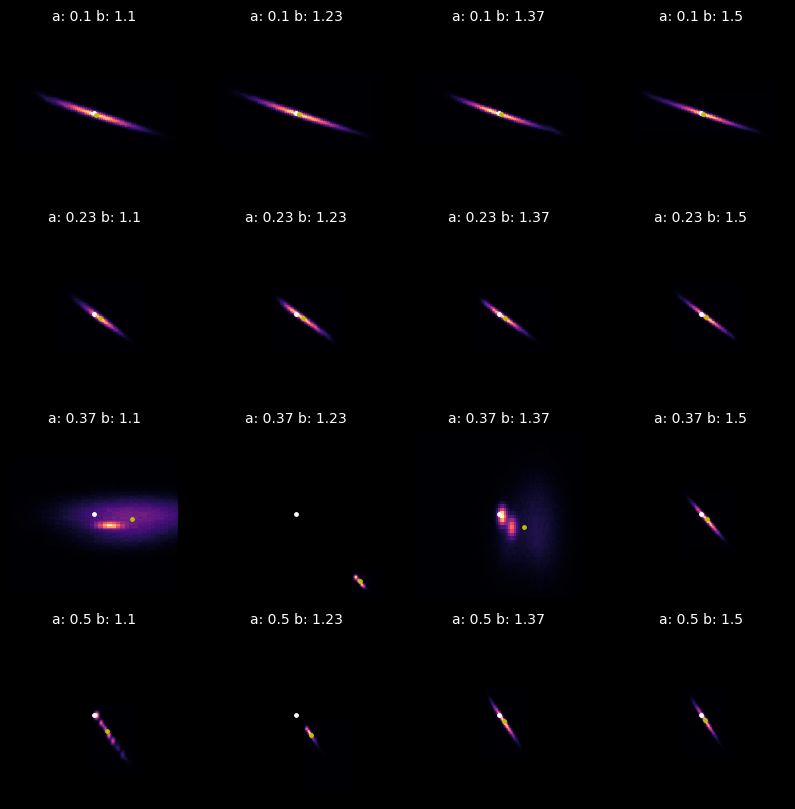

In [95]:
fig, axs = plt.subplots(4, 4, figsize = (10,10))
fig.patch.set_facecolor('black')
dy = 0.05

dx = 0.18
for i,a in enumerate(a_vals):
    for j,b in enumerate(b_vals):
        Xs = samples_ary[i,j]
        axs[i,j].set_facecolor("black")
        axs[i,j].hist2d(Xs[:,1],Xs[:,0],bins = 100,cmap = "magma") 
        axs[i,j].scatter(b,a, s = 6, c = "w")
        axs[i,j].scatter(moments[i,j][1],moments[i,j][0], s = 6, c = "y")
        axs[i,j].set_xticks([])
        axs[i,j].set_title("a: " + str(np.around(a,2)) + " " + "b: " + str(np.around(b,2)), color = 'white', fontsize = 10)
        axs[i,j].set_yticks([])
        axs[i,j].set_ylim((a-dy,a+dy))
        axs[i,j].set_xlim((b-dx,b+dx))

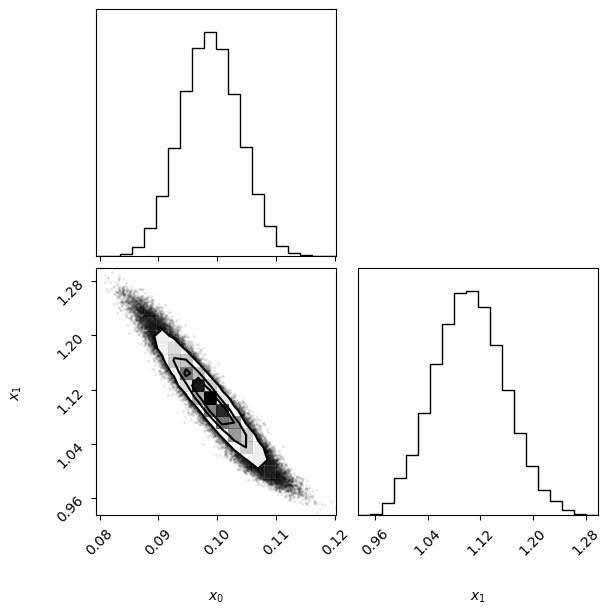

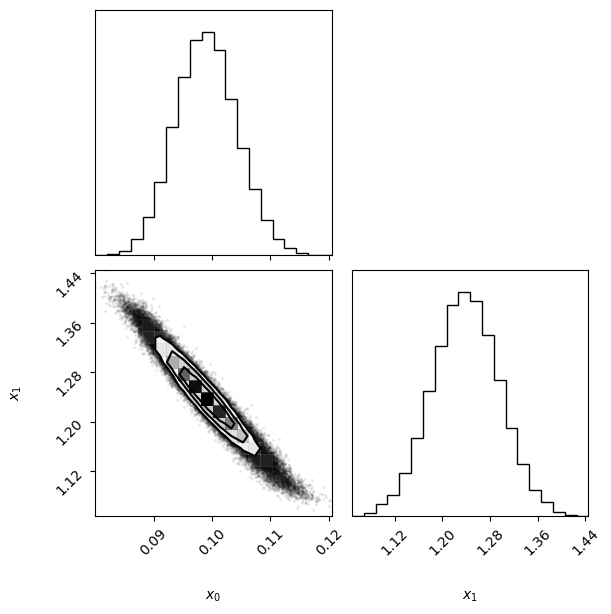

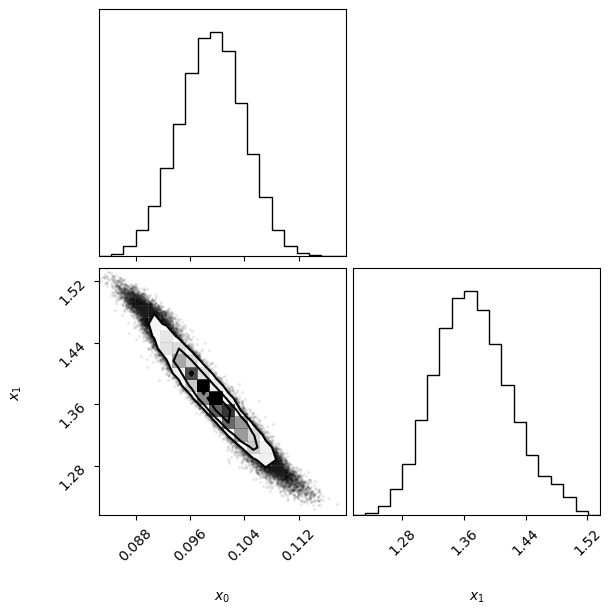

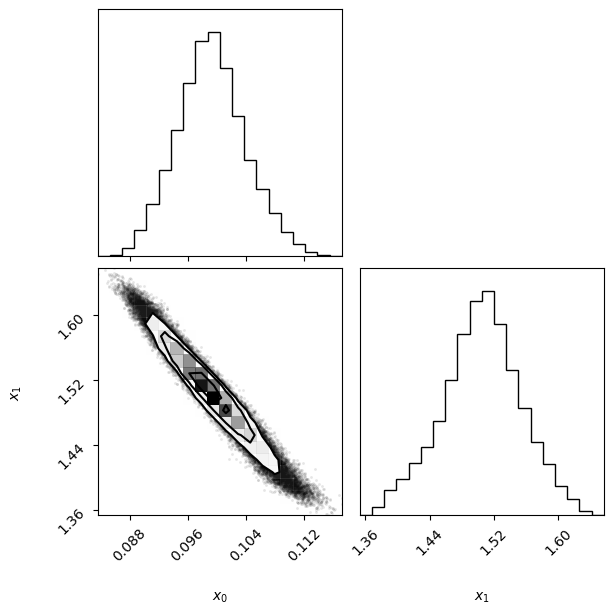

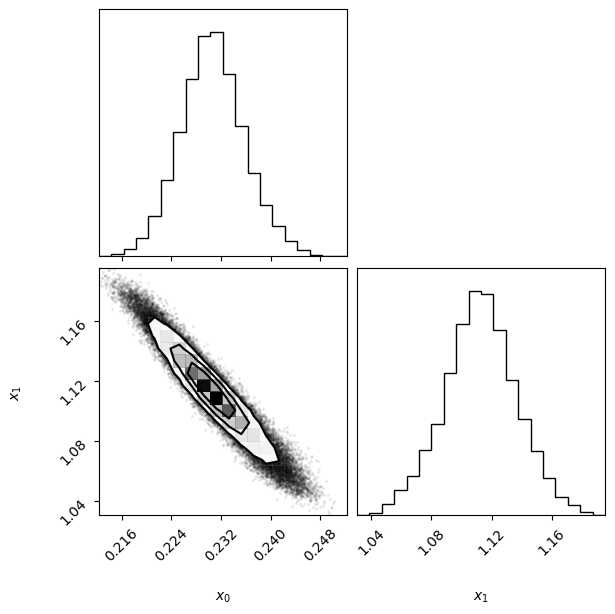

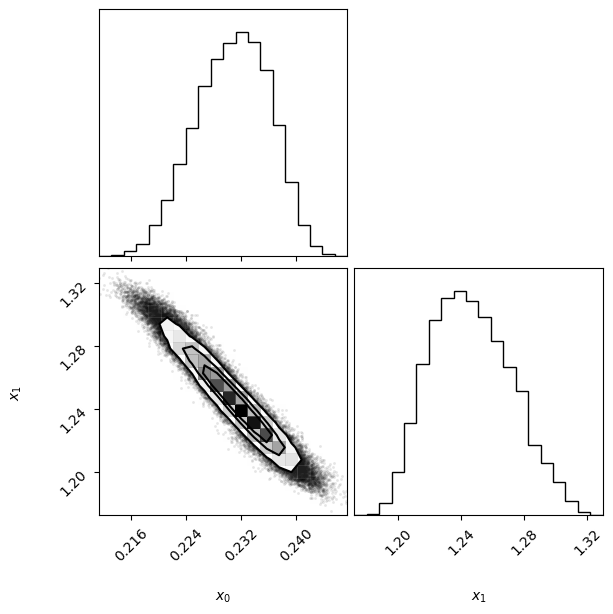

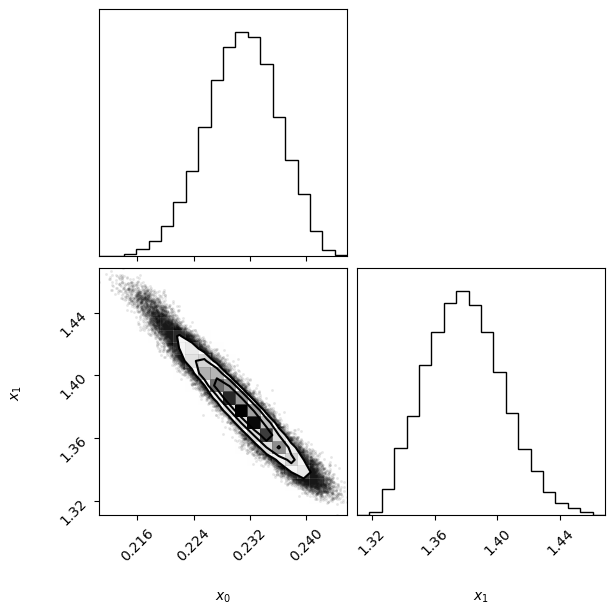

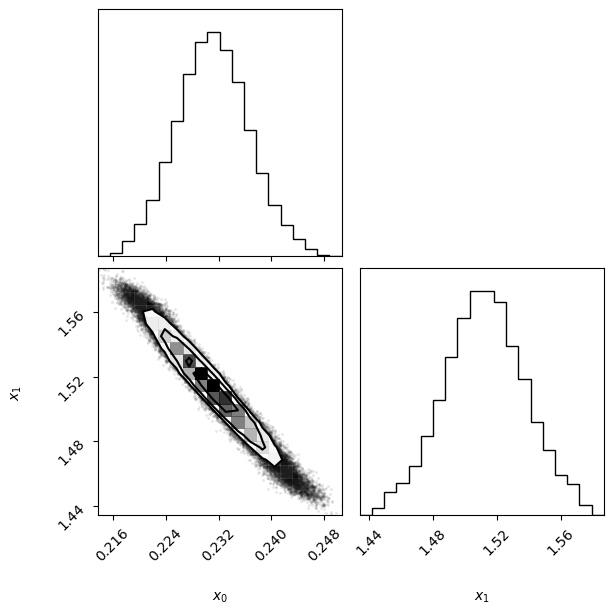

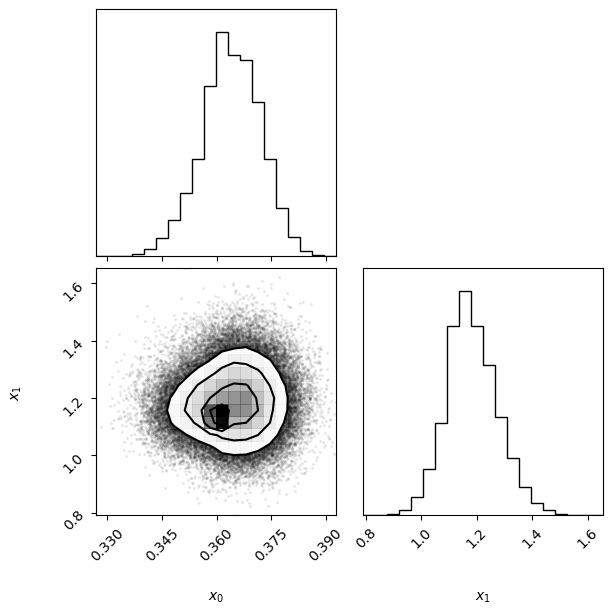

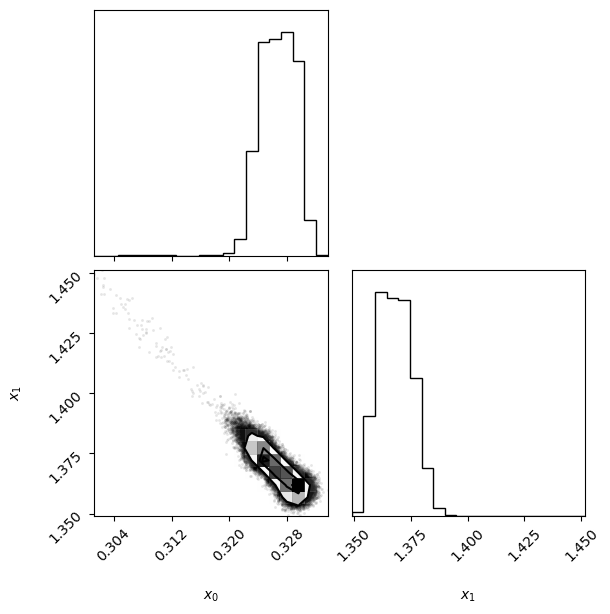

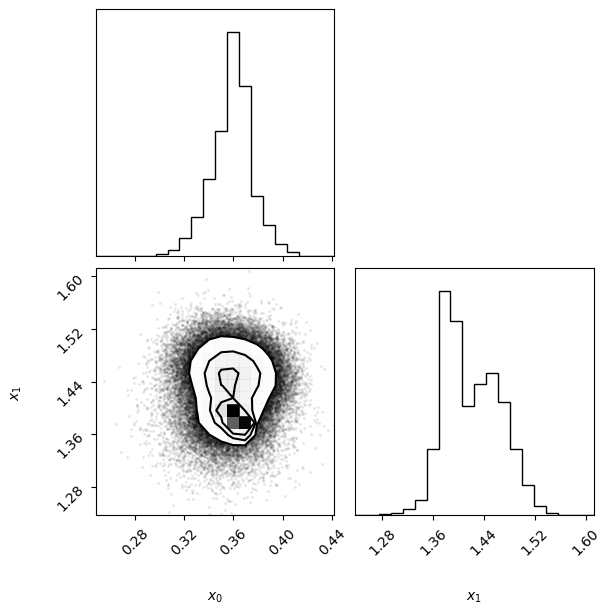

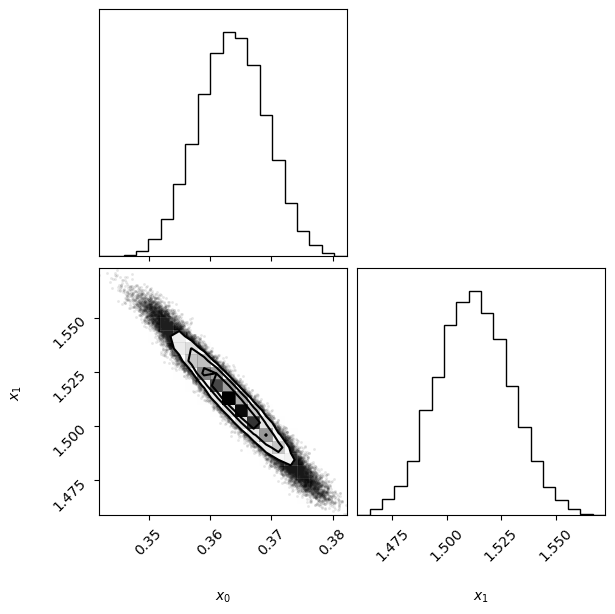

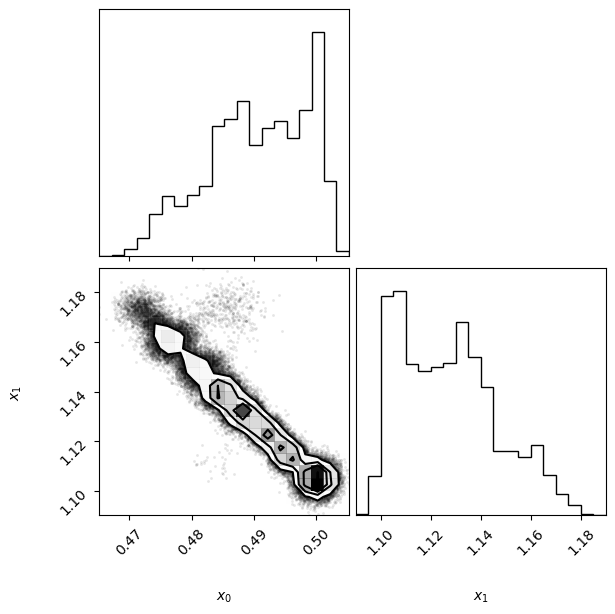

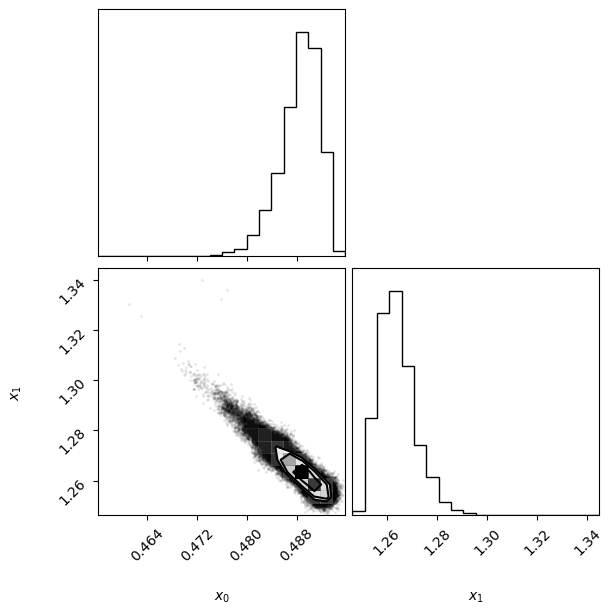

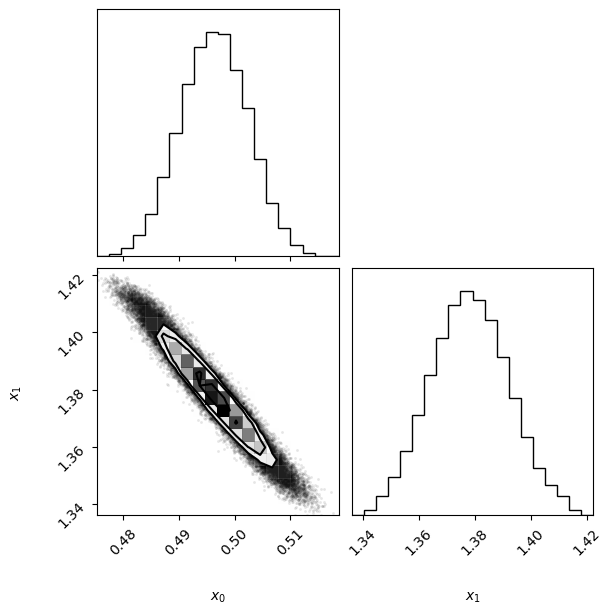

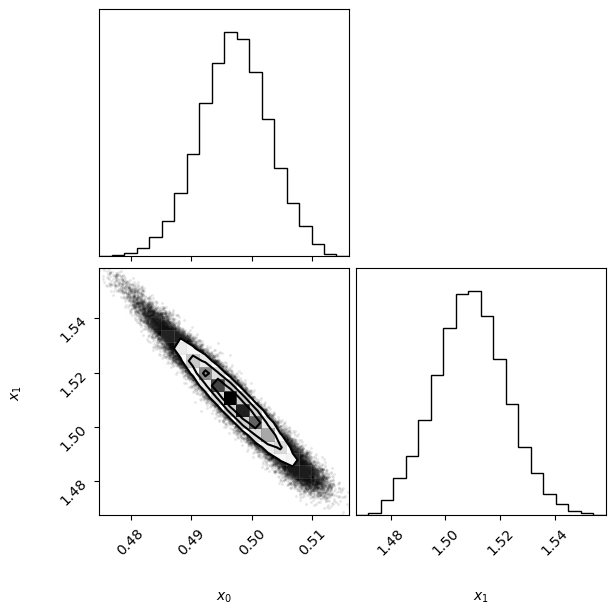

In [27]:
for vp in vps:
    vp.plot();